In [46]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree , metrics
import matplotlib.pyplot as plt
import joblib
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KPA2877\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KPA2877\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KPA2877\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# Custom transformer for text cleaning
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self._clean_text)
    
    def _clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return tokens

In [48]:
# Custom transformer for Word2Vec vectorization
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=200, window=10, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
    
    def fit(self, X, y=None):
        self.model = Word2Vec(X, vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.model.train(X, total_examples=len(X), epochs=100)
        return self
    
    def transform(self, X, y=None):
        return np.array([self._vectorize_text(text) for text in X])
    
    def _vectorize_text(self, text):
        vector = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
        return vector

In [49]:
# Load your dataset
df = pd.read_excel(r'Benefit Package.xlsx')
# df['cleaned_text'] = df['text_column'].apply(clean_text)

In [50]:
df

Sentence  Tag
0    member called to request information about cla...    0
1    which plan is the member referring to oy the m...    0
2    member grievance and appeal tor medicare calls...    0
3    advised that her plan is currently active ther...    0
4    grievance appeal jasmine an details which plan...    0
..                                                 ...  ...
905  aor on file member calling to submit a complai...    0
906  created by created date comments time to get a...    0
907  medicaid do not read follow mentor “ member gr...    0
908  drug patches not provided date the would like ...    0
909  allegation made the officebuilding is dirty er...    0

[910 rows x 2 columns]

In [51]:
X = df['Sentence']
y = df['Tag']

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [53]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [54]:
class_weights_dict

{0: 0.563273727647868, 1: 4.451086956521739}

In [55]:
# Pipeline
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('vectorizer', Word2VecVectorizer()),
    ('classifier', RandomForestClassifier(class_weight=class_weights_dict, random_state=42))
])

In [56]:
# Hyperparameter tuning with RandomizedSearchCV
param_distributions={'classifier__criterion':['entropy','gini'],
            'classifier__max_depth': [5,7,9],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__min_samples_leaf': [50,100] ,
            'classifier__min_samples_split': [50,100],
            'classifier__n_estimators': [100]}

In [57]:
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions, n_iter=5, cv=3, n_jobs=1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=100, classifier__min_samples_split=100, classifier__n_estimators=100; total time=  44.4s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=100, classifier__min_samples_split=100, classifier__n_estimators=100; total time=  44.3s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=100, classifier__min_samples_split=100, classifier__n_estimators=100; total time=  43.7s
[CV] END classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=sqrt, classifier__min_samples_leaf=50, classifier__min_samples_split=50, classifier__n_estimators=100; total time=  44.9s
[CV] END classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=sqrt, class

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cleaner', TextCleaner()),
                                             ('vectorizer',
                                              Word2VecVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier(class_weight={0: 0.563273727647868,
                                                                                   1: 4.451086956521739},
                                                                     random_state=42))]),
                   n_iter=5, n_jobs=1,
                   param_distributions={'classifier__criterion': ['entropy',
                                                                  'gini'],
                                        'classifier__max_depth': [5, 7, 9],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': [50,
                                                                         100],
                                        'classifier__min_samples_split': [50,
                                                                          100],
                                        'classifier__n_estimators': [100]},
                   random_state=42, verbose=2)

In [58]:
# Best model
best_pipeline = random_search.best_estimator_


In [59]:
#===================== Evaluation on Training Data =====================
y_pred_train = (best_pipeline.predict_proba(X_train)[:,1]>0.3).astype('int')
cnf_matrix = confusion_matrix(y_train, y_pred_train)
print('cnf_matrix \n',cnf_matrix)

acc_score = accuracy_score(y_train, y_pred_train)
print('Accuracy :', acc_score)

clf_report = classification_report(y_train,y_pred_train)
print('Classification Report :\n',clf_report)


cnf_matrix 
 [[352 375]
 [  0  92]]
Accuracy : 0.5421245421245421
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.48      0.65       727
           1       0.20      1.00      0.33        92

    accuracy                           0.54       819
   macro avg       0.60      0.74      0.49       819
weighted avg       0.91      0.54      0.62       819



0.5384615384615384
[[41 40]
 [ 2  8]]
              precision    recall  f1-score   support

           0       0.95      0.51      0.66        81
           1       0.17      0.80      0.28        10

    accuracy                           0.54        91
   macro avg       0.56      0.65      0.47        91
weighted avg       0.87      0.54      0.62        91



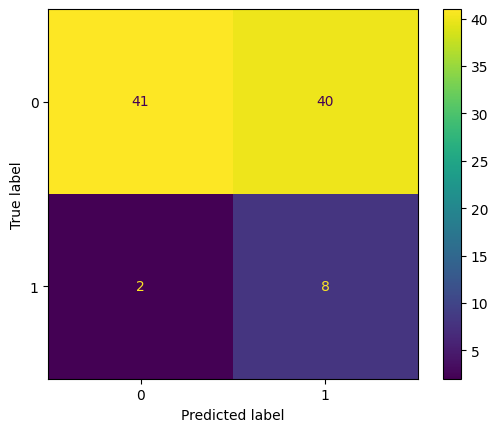

In [60]:
#===================== Threshold Value Manipulation =====================
y_pred_thr = (best_pipeline.predict_proba(X_test)[:,1]>0.3).astype('int')
print(accuracy_score(y_test,y_pred_thr))
print(confusion_matrix(y_test,y_pred_thr))

print(classification_report(y_test,y_pred_thr))

cfm=confusion_matrix(y_test, y_pred_thr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cfm)
cm_display.plot()
plt.show()


In [61]:
#==================Model Saving ============
# pickle.dump(XGB, open("FR_COB_XGBoost.pkl",'wb'))
# pickle.dump(std, open("FR_COB_XGBoost_std.pkl",'wb'))

joblib.dump(best_pipeline, r'C:\Users\KPA2877\Documents\Model (10)\Benefit Package\RF.pkl')
# selected_column.to_csv(r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\Medicare\Model\Medicare_ver13\Random_Forest\selected_column_RF_ver13.csv')
# joblib.dump(std_train, r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\Medicare\Model\Medicare_ver13\Random_Forest\std_RF_ver13.pkl')
# ml_Load = joblib.load('U:/Documents/RNPOS_SCRCP/rnpos_scrcp.pkl')
# ml_Load.predict(Train_X_std_RF_model)

['C:\\Users\\KPA2877\\Documents\\Model (10)\\Benefit Package\\RF.pkl']

In [62]:
#==================Loading model=======
best_pipeline_loaded = joblib.load(r'C:\Users\KPA2877\Documents\Model (10)\Benefit Package\RF.pkl')

In [66]:
# Load your dataset
df_val = pd.read_excel(r'DATA_VAL_NS.xlsx')
# df['cleaned_text'] = df['text_column'].apply(clean_text)

In [67]:
X_val = df_val['Sentence']
y_val = df_val['Tag']

0.6193548387096774
[[78 57]
 [ 2 18]]
              precision    recall  f1-score   support

           0       0.97      0.58      0.73       135
           1       0.24      0.90      0.38        20

    accuracy                           0.62       155
   macro avg       0.61      0.74      0.55       155
weighted avg       0.88      0.62      0.68       155



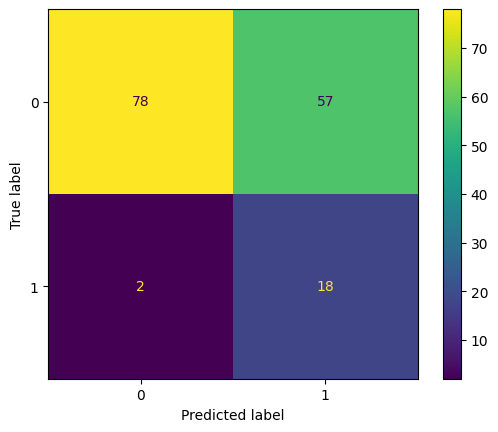

In [68]:
#===================== Threshold Value Manipulation =====================
y_pred_thr_val = (best_pipeline_loaded.predict_proba(X_val)[:,1]>0.3).astype('int')
print(accuracy_score(y_val,y_pred_thr_val))
print(confusion_matrix(y_val,y_pred_thr_val))

print(classification_report(y_val,y_pred_thr_val))

cfm=confusion_matrix(y_val, y_pred_thr_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cfm)
cm_display.plot()
plt.show()

In [69]:
data = pd.DataFrame(y_pred_thr_val)

In [70]:
data.to_excel('result.xlsx',index=True,header=True)